## Classification of MNIST dataset with tensor networks

In [1]:
# import packages here
# --------------------------------------
import matplotlib.pyplot as plt

import qtealeaves as qtl
from qtealeaves.convergence_parameters.conv_params import TNConvergenceParameters
from qtealeaves.emulator.mps_simulator import MPS
from qtealeaves.emulator import StateVector

from tensorflow.keras.datasets import mnist
import numpy as np


2024-05-23 12:31:00.934434: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 12:31:00.936092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 12:31:00.967849: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 12:31:00.968839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 12:31:01.470665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Load MNIST dataset

In [2]:
# Load dataset here
# --------------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28)
(10000, 28, 28)


In [3]:
# Selecting only images with the numbers 3 and 8
train_filter = np.where((y_train == 3 ) | (y_train == 8))
test_filter = np.where((y_test == 3) | (y_test == 8))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

train_idxs_3 = np.where(y_train == 3)
train_idxs_8 = np.where(y_train == 8)
test_idxs_3 = np.where(y_test == 3)
test_idxs_8 = np.where(y_test == 8)

y_train[train_idxs_3] = 0
y_train[train_idxs_8] = 1
y_test[test_idxs_3] = 0
y_test[test_idxs_8] = 1

# Reduce amount of images
nr_images = 100
nr_images_test = nr_images * 100
x_train, y_train, x_test, y_test = x_train[:nr_images, :, :], y_train[:nr_images], x_test[:nr_images_test, :, :], y_test[:nr_images_test]

x_train = x_train / 255
x_test = x_test / 255

np.random.seed(42)
x_train = np.random.RandomState(seed=42).permutation(x_train)
y_train = np.random.RandomState(seed=42).permutation(y_train)
x_test = np.random.RandomState(seed=42).permutation(x_test)
y_test = np.random.RandomState(seed=42).permutation(y_test)

0


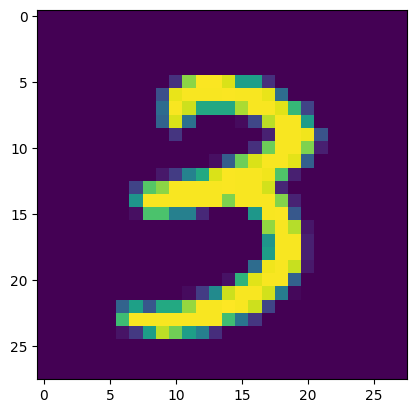

In [4]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0, :, :])
print(y_train[0])

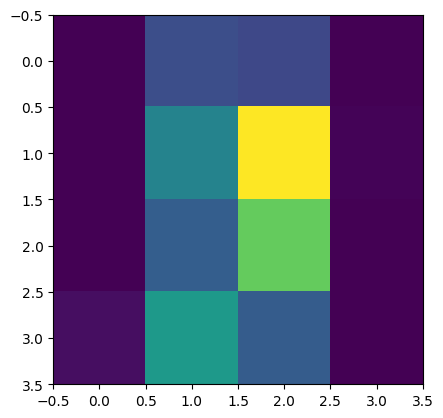

In [5]:
import skimage.measure

x_train = skimage.measure.block_reduce(x_train, (1,7, 7), np.mean)
x_test = skimage.measure.block_reduce(x_test, (1,7,7), np.mean)

plt.imshow(x_train[0, :, :])




In [6]:
import tensorflow as tf

test = (x_test, y_test)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(4, 4)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

History = model.fit(x_train, y_train, epochs=100,validation_data=test,
)

Epoch 1/100


2024-05-23 12:31:02.887456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 12:31:02.889784: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 63ms/step - loss: 0.6989 - binary_accuracy: 0.5500 - val_loss: 0.7001 - val_binary_accuracy: 0.5091
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 0.6904 - binary_accuracy: 0.5500 - val_loss: 0.6935 - val_binary_accuracy: 0.5091
Epoch 3/100
4/4 [==============================] - 0s 26ms/step - loss: 0.6827 - binary_accuracy: 0.5500 - val_loss: 0.6871 - val_binary_accuracy: 0.5091
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 0.6744 - binary_accuracy: 0.5500 - val_loss: 0.6805 - val_binary_accuracy: 0.5091
Epoch 5/100
4/4 [==============================] - 0s 22ms/step - loss: 0.6664 - binary_accuracy: 0.5500 - val_loss: 0.6740 - val_binary_accuracy: 0.5091
Epoch 6/100
4/4 [==============================] - 0s 26ms/step - loss: 0.6591 - binary_accuracy: 0.5500 - val_loss: 0.6674 - val_binary_accuracy: 0.5091
Epoch 7/100
4/4 [==============================] - 0s 26ms/step - loss: 0.6512 - binary_

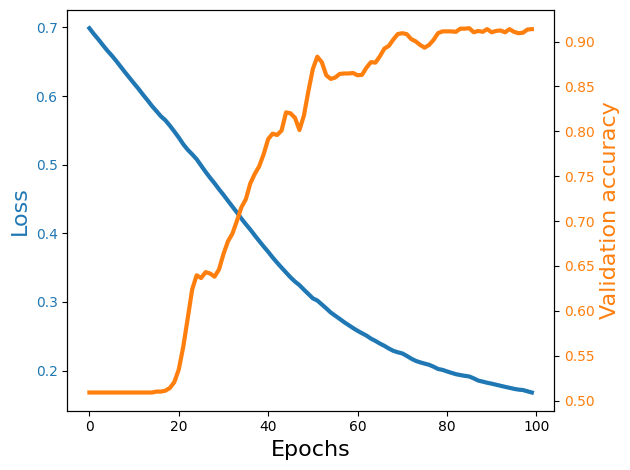

In [7]:
loss = list(History.history.values())[0]
acc = list(History.history.values())[1]
val_loss = list(History.history.values())[2]
val_acc = list(History.history.values())[3]

# plt.plot(loss, label = 'Training Loss')
# plt.plot(val_acc, label = 'Validation accuracy')
# plt.ylabel('Loss')



fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epochs', fontsize = 16)
ax1.set_ylabel('Loss', color=color, fontsize = 16)
ax1.plot(loss, color=color, lw = 3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Validation accuracy', color=color, fontsize = 16)  # we already handled the x-label with ax1
ax2.plot(val_acc, color=color, lw = 3)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('figs/loss_NN.png')



In [ ]:
model.summary()

In [ ]:
# Visualize weights matrix

plt.imshow(np.expand_dims(model.weights[0], axis = -1), cmap='plasma', interpolation='none')
plt.xticks([], [])
plt.yticks([], [])
plt.savefig('weights1.png')

In [ ]:
w = np.array(model.weights[0])

w.shape

# 

In [ ]:
u, s, vh = np.linalg.svd(w, full_matrices = False)

x = np.arange(len(s))

plt.scatter(x, s, color = 'gray', edgecolors='k', s = 100)
plt.ylabel('Singular Values', fontsize = 14)
plt.xlabel('Diagonal entries', fontsize = 14)

In [ ]:
# Truncating the singular value matrix while keeping the truncated W matrix the same shape as the initial W matrix

k = 2

u_tr = u[:, :k]
s_tr = np.eye(len(s[:k])) * s[:k]
vh_tr = vh[:k, :]

w_tr = u_tr @ s_tr @ vh_tr

w_tr.shape

In [ ]:
w = np.array(model.weights[0])
bias = model.layers[1].weights[1] 
loss_mpo_l = []
acc_mpo_l = []
for k in range (1,100):
    u, s, vh = np.linalg.svd(w, full_matrices = False)
    u_tr = u[:, :k]
    s_tr = np.eye(len(s[:k])) * s[:k]
    vh_tr = vh[:k, :]

    w_tr = u_tr @ s_tr @ vh_tr

    model.layers[1].set_weights([w_tr, bias]) 
    history_mpo = model.evaluate(x_test, y_test)
    loss_mpo = history_mpo[0]
    acc_mpo = history_mpo[1]
    loss_mpo_l.append(loss_mpo)
    acc_mpo_l.append(acc_mpo)

In [ ]:
plt.plot(acc_mpo_l, lw = 3)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Singular Values Kept', fontsize = 14)



In [ ]:
# get the bias corresponding to the layer we want to put the weights in
bias = model.layers[1].weights[1] 

print(w_tr)
model.layers[1].set_weights([w_tr, bias])  
print(model.weights[0])  


In [ ]:
x = np.random.rand(500, 4, 4)

output = model(x)

In [ ]:
def mpo(w, d):

    w_rsh = np.reshape(w, (2, 8, 4, 32))

    w_rsh_p = np.transpose(w_rsh, (0, 2, 1, 3))


    w_rsh_p_r = np.reshape(w_rsh_p, (8, 256))

    u, s, vh = np.linalg.svd(w_rsh_p_r, full_matrices = False)

    s_mat = np.eye(len(s[:])) * s

    vh2 = np.reshape(vh, (8, 8, 32))

    w_next = s_mat @ vh2

    w_next2 = u @ w_next
    

    w_next2 = np.reshape(w_next2, (8, 2, 4, 4, 8))

    w_next2 = np.transpose(w_next2, (0,1,3,2,4))

    w_next2 = np.reshape(w_next2, (64, 32))

    u, s, vh = np.linalg.svd(w_next2, full_matrices = False)

    u = u[:, :d]
    s_mat = np.eye(len(s[:d])) * s[:d]
    vh = vh[:d, :]
    

    w_next = s_mat @ vh


    w_next2 = u @ vh
    
    w_next2 = np.reshape(w_next2, (512, 4))

    u, s, vh = np.linalg.svd(w_next2, full_matrices = False)

    u = u[:, :d]
    s_mat = np.eye(len(s[:d])) * s[:d]
    vh = vh[:d, :]

    
    w_next = s_mat @ vh


    w_next2 = u @ vh
    
    
    w_final = np.reshape(w_next2, (8, 64, 2, 2))

    w_final = np.transpose(w_final, (0, 2, 1, 3))

    w_final = np.reshape(w_final, (16, 128))

    return w_final
    
    


In [ ]:
def mpo2(w, d):

    w_rsh = np.reshape(w, (2, 8, 4, 32))

    w_rsh_p = np.transpose(w_rsh, (0, 2, 1, 3))


    w_rsh_p_r = np.reshape(w_rsh_p, (8, 256))

    u, s, vh = np.linalg.svd(w_rsh_p_r, full_matrices = False)

    s_mat = np.eye(len(s[:])) * s

    vh2 = np.reshape(vh, (8, 8, 32))

    w_next = s_mat @ vh2

    w_next2 = u @ w_next
    

    w_next2 = np.reshape(w_next2, (8, 2, 4, 4, 8))

    w_next2 = np.transpose(w_next2, (0,1,3,2,4))

    w_next2 = np.reshape(w_next2, (64, 32))

    u, s, vh = np.linalg.svd(w_next2, full_matrices = False)

    u = u[:, :d]
    s_mat = np.eye(len(s[:d])) * s[:d]
    vh = vh[:d, :]
    

    w_next = s_mat @ vh


    w_next2 = u @ vh
    
    w_next2 = np.reshape(w_next2, (512, 4))

    u, s, vh = np.linalg.svd(w_next2, full_matrices = False)

    u = u[:, :d]
    s_mat = np.eye(len(s[:d])) * s[:d]
    vh = vh[:d, :]

    
    w_next = s_mat @ vh


    w_next2 = u @ vh
    
    
    w_final = np.reshape(w_next2, (8, 64, 2, 2))

    # w_final = np.transpose(w_final, (0, 2, 1, 3))

    # w_final = np.reshape(w_final, (16, 128))

    w_final = np.transpose(w_final, (0, 2, 4, 6, 1, 3, 5, 7))

    w_final = np.reshape(16, 128)

    return w_final
    
    
w_f = mpo2(w, 4)

In [ ]:
# get the bias corresponding to the layer we want to put the weights in
bias = model.layers[1].weights[1] 



In [ ]:
History = model.evaluate(x_test, y_test)

In [ ]:
loss_mpo = History[0]
acc_mpo = History[1]



In [ ]:
loss_mpo_l = []
acc_mpo_l = []

for d in range(2, 100):
    w_f = mpo2(w, d)
    model.layers[1].set_weights([w_f, bias]) 
    history_mpo = model.evaluate(x_test, y_test)
    loss_mpo = history_mpo[0]
    acc_mpo = history_mpo[1]
    loss_mpo_l.append(loss_mpo)
    acc_mpo_l.append(acc_mpo)

    

In [ ]:
plt.plot(acc_mpo_l)